In [28]:
library(rethinking)
library(tidyverse)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/jw/.cmdstan/cmdstan-2.32.2

- CmdStan version: 2.32.2

Loading required package: parallel

rethinking (Version 2.31)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2  

In [2]:
f <- alist(
    y ~ dnorm( mu , sigma ),
    mu ~ dnorm( 0 , 10 ),
    sigma ~ dexp( 1 )
)

fit <- quap( 
    f , 
    data=list(y=c(-1,1)) , 
    start=list(mu=0,sigma=1)
)

In [3]:
summary(fit)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.0000000,0.5924240,-0.9468080,0.946808
sigma,0.8392882,0.3287434,0.3138927,1.364684


In [26]:
data( UCBadmit )
UCBadmit$male <- as.integer(UCBadmit$applicant.gender=="male")
UCBadmit$dept <- rep( 1:6 , each=2 )
UCBadmit$applicant.gender <- NULL
UCBadmit <- UCBadmit |> rename(rjct = reject) 

In [27]:
UCBadmit

,dept,admit,rjct,applications,male
,<int>,<int>,<int>,<int>,<int>
1,1,512,313,825,1
2,1,89,19,108,0
3,2,353,207,560,1
4,2,17,8,25,0
5,3,120,205,325,1
6,3,202,391,593,0
7,4,138,279,417,1
8,4,131,244,375,0
9,5,53,138,191,1


In [31]:
m_glmm1 <- alist(
    admit ~ binomial(applications,p),
    logit(p) <- a[dept] + b*male,
    a[dept] ~ normal( abar , sigma ),
    abar ~ normal( 0 , 4 ),
    sigma ~ half_normal(0,1),
    b ~ normal(0,1)
) |>
ulam( cmdstan =  TRUE, data=UCBadmit , log_lik=TRUE )
WAIC(m_glmm1)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.


WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
107.9614,-44.95019,9.030492,15.7139


In [34]:
summary(m_glmm1)

Inference for Stan model: ulam_cmdstanr_aa44ba7c094457bcc232d15eb60a01a1-202307150415-1-012f27.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                mean se_mean   sd     2.5%      25%      50%      75%    97.5%
a[1]            0.67    0.01 0.09     0.49     0.62     0.68     0.73     0.85
a[2]            0.63    0.01 0.12     0.40     0.55     0.63     0.71     0.86
a[3]           -0.59    0.00 0.07    -0.72    -0.64    -0.59    -0.54    -0.45
a[4]           -0.62    0.00 0.09    -0.81    -0.67    -0.61    -0.56    -0.47
a[5]           -1.05    0.01 0.10    -1.26    -1.12    -1.05    -0.99    -0.88
a[6]           -2.60    0.01 0.15    -2.91    -2.70    -2.60    -2.49    -2.28
abar           -0.59    0.02 0.54    -1.77    -0.91    -0.57    -0.25     0.54
sigma           1.27    0.02 0.37     0.71     1.01     1.20     1.50     2.15
b              -0.09    0.01 0.08    -0.23    -0.14    -0.10    -0.04     0.06

In [35]:
m_glmm1

Hamiltonian Monte Carlo approximation
500 samples from 1 chain

Sampling durations (seconds):
        warmup sample total
chain:1   0.01   0.01  0.03

Formula:
admit ~ binomial(applications, p)
logit(p) <- a[dept] + b * male
a[dept] ~ normal(abar, sigma)
abar ~ normal(0, 4)
sigma ~ half_normal(0, 1)
b ~ normal(0, 1)

In [29]:
stancode(m_glmm1)

data{
    array[12] int rjct;
    array[12] int applications;
    array[12] int admit;
    array[12] int male;
    array[12] int dept;
}
parameters{
     vector[6] a;
     real abar;
     real<lower=0> sigma;
     real b;
}
model{
     vector[12] p;
    b ~ normal( 0 , 1 );
    sigma ~ normal( 0 , 1 );
    abar ~ normal( 0 , 4 );
    a ~ normal( abar , sigma );
    for ( i in 1:12 ) {
        p[i] = a[dept[i]] + b * male[i];
        p[i] = inv_logit(p[i]);
    }
    admit ~ binomial( applications , p );
}
generated quantities{
    vector[12] log_lik;
     vector[12] p;
    for ( i in 1:12 ) {
        p[i] = a[dept[i]] + b * male[i];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:12 ) log_lik[i] = binomial_lpmf( admit[i] | applications[i] , p[i] );
}



In [41]:
data(UCBadmit)
# UCBadmit <- UCBadmit |> rename(rjct = reject) 


# varying intercepts
f3 <- admit ~ (1|dept) + applicant.gender
m3 <- glimmer( f3 , UCBadmit , binomial )
m3s <- ulam( m3$f , data=m3$d )

alist(
    admit ~ dbinom( 1 , p ),
    logit(p) <- Intercept +
        b_applicant_gendermale*applicant_gendermale +
        v_Intercept[dept],
    Intercept ~ dnorm(0,10),
    b_applicant_gendermale ~ dnorm(0,10),
    v_Intercept[dept] ~ dnorm(0,sigma_dept),
    sigma_dept ~ dcauchy(0,2)
)
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: binomial_lpmf: Successes variable[1] is 512, but must be in the interval [0, 1] (in '/tmp/RtmpoXf2zh/model-347adcb45.stan', line 27, column 4 to column 30)

Chain 1 Exception: binomial_lpmf: Successes variable[1] is 512, but must be in the interval [0, 1] (in '/tmp/RtmpoXf2zh/model-347adcb45.stan', line 27, column 4 to column 30)

Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the initial value.

Chain 1 Exception: binomial_lpmf: Successes variable[1] is 512, but must be in the interval [0, 1] (in '/tmp/RtmpoXf2zh/model-347adcb45.stan', line 27, column 4 to column 30)

Chain 1 Exception: binomial_lpmf: Successes variable[1] is 512, but must be in the interval [0, 1] (in '/tmp/RtmpoXf2zh/model-347adcb45.stan', line 27, column 4 to column 30)

Chain 1 Rejecting initial value:

Chain 1   Error evaluating the log probability at the 

ERROR: Error in rstan::read_stan_csv(cmdstanfit$output_files()): csvfiles does not contain any CSV file name


In [43]:
# varying intercepts and slopes
f4 <- admit ~ (1+applicant.gender|dept) + applicant.gender
m4 <- glimmer( f4 , UCBadmit , binomial )
m4s <- ulam( m4$f , data=m4$d )

alist(
    admit ~ dbinom( 1 , p ),
    logit(p) <- Intercept +
        b_applicant_gendermale*applicant_gendermale +
        v_Intercept[dept] +
        v_applicant_gendermale[dept]*applicant_gendermale,
    Intercept ~ dnorm(0,10),
    b_applicant_gendermale ~ dnorm(0,10),
    c(v_Intercept,v_applicant_gendermale)[dept] ~ dmvnorm2(0,sigma_dept,Rho_dept),
    sigma_dept ~ dcauchy(0,2),
    Rho_dept ~ dlkjcorr(2)
)


ERROR: Error in get_dist_template(the_dist[1]): No template for distribution 'dmvnorm2'


[1] 0.1771581

In [117]:

gen_binary <- \(n) rbinom(n=n, size = 1, prob=runif(1))

set.seed(12345)
toy_data <- tibble(
    id = paste0('s', str_pad(1:1000, 4, side = 'left', '0')),
    x1 = gen_binary(1000),
    x2 = gen_binary(1000),
    x3 = gen_binary(1000),
    x4 = gen_binary(1000),
    x5 = gen_binary(1000)
)

toy_data_long <- toy_data |>
    pivot_longer(!id, names_to = 'item', values_to = 'resp') 

toy_data_long$id <- as.factor(toy_data_long$id)
toy_data_long$item <- as.factor(toy_data_long$item)

glimpse(toy_data_long)


Rows: 5,000
Columns: 3
$ id   <fct> s0001, s0001, s0001, s0001, s0001, s0002, s0002, s0002, s0002, s0…
$ item <fct> x1, x2, x3, x4, x5, x1, x2, x3, x4, x5, x1, x2, x3, x4, x5, x1, x…
$ resp <int> 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,…


In [109]:
# varying intercepts
f3 <- resp ~ 0 + item + (1|id)
m3 <- glimmer( f3 , toy_data , binomial)
m3s <- map2stan( m3$f , data=m3$d )

ERROR: Error in eval(predvars, data, env): object 'resp' not found


In [100]:
summary(m3s)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': object 'm3s' not found


In [110]:
m_rasch <- alist(
    resp ~ bernoulli( p ),
   logit(p) <- v_Intercept[id],
    v_Intercept[id] ~ dnorm(0,sigma_id),
    sigma_id ~ dcauchy(0,1)
) |>
ulam( cmdstan =  TRUE, data=toy_data_long, log_lik=TRUE )

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpAVMDGH/model-304335922f77.stan', line 13, column 4 to column 41)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 7.6 seconds.


See https://mc-stan.org/misc/warnings for details.




In [118]:
m_rasch <- alist(
    resp ~ bernoulli( p ),
   logit(p) <- b_item[item]+v_Intercept[id],
    b_item[item] ~ dnorm(0,10),
    v_Intercept[id] ~ dnorm(0,sigma_id),
    sigma_id ~ dcauchy(0,1)
) |>
ulam( cmdstan =  TRUE, 
     data=toy_data_long, 
     log_lik=TRUE,
     chains=4, cores=4
    )

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




In [123]:
rethinking::stancode(m_rasch)

data{
    array[5000] int resp;
    array[5000] int id;
    array[5000] int item;
}
parameters{
     vector[5] b_item;
     vector[1000] v_Intercept;
     real<lower=0> sigma_id;
}
model{
     vector[5000] p;
    sigma_id ~ cauchy( 0 , 1 );
    v_Intercept ~ normal( 0 , sigma_id );
    b_item ~ normal( 0 , 10 );
    for ( i in 1:5000 ) {
        p[i] = b_item[item[i]] + v_Intercept[id[i]];
        p[i] = inv_logit(p[i]);
    }
    resp ~ bernoulli( p );
}
generated quantities{
    vector[5000] log_lik;
     vector[5000] p;
    for ( i in 1:5000 ) {
        p[i] = b_item[item[i]] + v_Intercept[id[i]];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:5000 ) log_lik[i] = bernoulli_lpmf( resp[i] | p[i] );
}



In [160]:
?quap

quap {rethinking},R Documentation
flist,A formula or alist of formulas that define the likelihood and priors. See details.
data,A data frame or list containing the data
start,Optional named list specifying parameters and their initial values
method,Search method for optim. Defaults to BFGS.
hessian,"If TRUE, attempts to compute the Hessian"
debug,"If TRUE, prints various internal steps to help with debugging"
...,Additional arguments to pass to optim
call,The function call
coef,The estimated posterior modes
vcov,Variance-covariance matrix


In [131]:
precis(m_rasch, pars = 'b_item', digits = 3, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b_item[1],0.9073110,0.07048125,0.79189473,1.0211422,1348.9190,1.009416
b_item[2],1.6806071,0.08874941,1.54171200,1.8238603,932.9792,1.013112
b_item[3],0.1806123,0.06469639,0.07421362,0.2850194,1211.4477,1.002046
b_item[4],1.2568756,0.07510828,1.13899765,1.3810004,928.4975,1.013610
b_item[5],-1.0404971,0.07232064,-1.15697970,-0.9279548,1255.9368,1.001732


In [55]:
library(brms)

Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following objects are masked from ‘package:rethinking’:

    LOO, stancode, WAIC


The following object is masked from ‘package:rstan’:

    loo


The following object is masked from ‘package:stats’:

    ar




In [79]:
bf <- resp ~ 0 + item + (1|id)
fit <- brm(formula = bf, data = toy_data_long, family = bernoulli(), cores = 4, backend = 'cmdstanr')

Start sampling



Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  400 / 200

See https://mc-stan.org/misc/warnings for details.




In [80]:
summary(fit)
prior_summary(fit)

Warning message:
“There were 44 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: bernoulli 
  Links: mu = logit 
Formula: resp ~ 0 + item + (1 | id) 
   Data: toy_data_long (Number of observations: 5000) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~id (Number of levels: 1000) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.10     0.01     0.39 1.02      333      856

Population-Level Effects: 
       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
itemx1     0.91      0.07     0.77     1.05 1.00     2919     1982
itemx2     1.68      0.09     1.51     1.85 1.00     3811     2599
itemx3     0.18      0.06     0.06     0.30 1.00     4086     2965
itemx4     1.26      0.08     1.11     1.41 1.00     4126     2580
itemx5    -1.04      0.07    -1.18    -0.90 1.00     4018     3033

Draws were sampled using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is 

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
,b,itemx1,,,,,,,default
,b,itemx2,,,,,,,default
,b,itemx3,,,,,,,default
,b,itemx4,,,,,,,default
,b,itemx5,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,default
,sd,,id,,,,,,default
,sd,Intercept,id,,,,,,default


In [102]:
stancode(fit)

// generated with brms 2.19.0
functions {
  
}
data {
  int<lower=1> N; // total number of observations
  array[N] int Y; // response variable
  int<lower=1> K; // number of population-level effects
  matrix[N, K] X; // population-level design matrix
  // data for group-level effects of ID 1
  int<lower=1> N_1; // number of grouping levels
  int<lower=1> M_1; // number of coefficients per level
  array[N] int<lower=1> J_1; // grouping indicator per observation
  // group-level predictor values
  vector[N] Z_1_1;
  int prior_only; // should the likelihood be ignored?
}
transformed data {
  
}
parameters {
  vector[K] b; // population-level effects
  vector<lower=0>[M_1] sd_1; // group-level standard deviations
  array[M_1] vector[N_1] z_1; // standardized group-level effects
}
transformed parameters {
  vector[N_1] r_1_1; // actual group-level effects
  real lprior = 0; // prior contributions to the log posterior
  r_1_1 = sd_1[1] * z_1[1];
  lprior += student_t_lpdf(sd_1 | 3, 0, 2.5)
            - 1 * student_t_lccdf(0 | 3, 0, 2.5);
}
model {
  // likelihood including constants
  if (!prior_only) {
    // initialize linear predictor term
    vector[N] mu = rep_vector(0.0, N);
    for (n in 1 : N) {
      // add more terms to the linear predictor
      mu[n] += r_1_1[J_1[n]] * Z_1_1[n];
    }
    target += bernoulli_logit_glm_lpmf(Y | X, mu, b);
  }
  // priors including constants
  target += lprior;
  target += std_normal_lpdf(z_1[1]);
}
generated quantities {
  
}

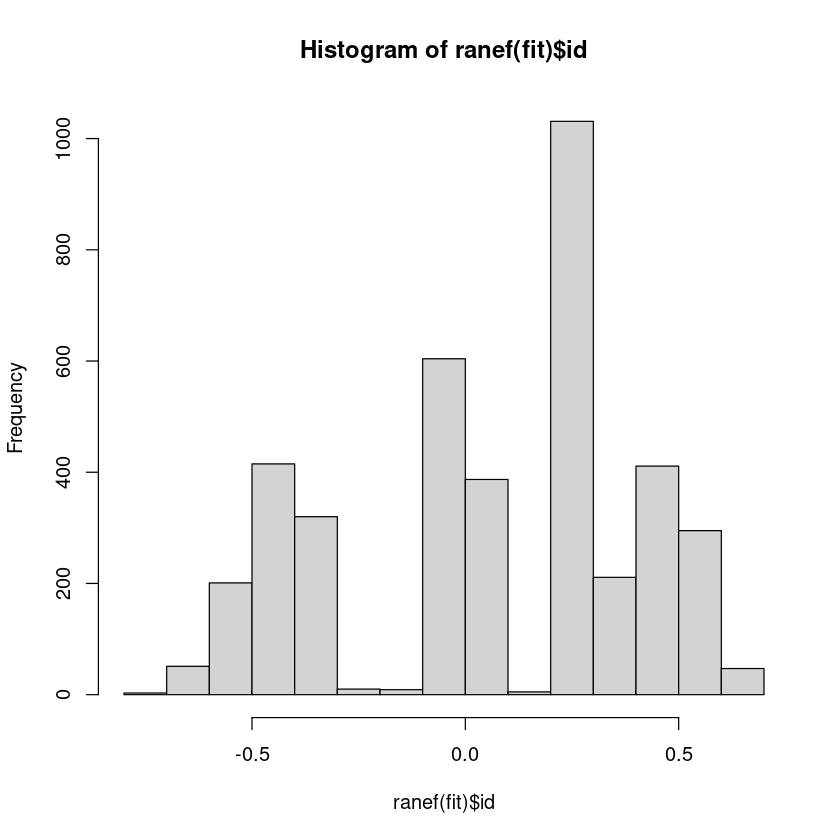

In [81]:
ranef(fit)$id |> hist(breaks = 20)

In [66]:
library(mirt)

Loading required package: stats4

Loading required package: lattice


Attaching package: ‘mirt’


The following object is masked from ‘package:brms’:

    fixef




In [82]:
fit_mirt <- mirt(toy_data[2:6], itemtype = 'Rasch')

Iteration: 286, Log-Lik: -2839.961, Max-Change: 0.00010


In [132]:
# brms
print(fit, digits = 8)
# mirt
coef(fit_mirt, simplify = TRUE, IRTparameter = TRUE)
# ulam
precis(m_rasch, pars = 'b_item', digits = 3, depth=2)

Warning message:
“There were 44 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: bernoulli 
  Links: mu = logit 
Formula: resp ~ 0 + item + (1 | id) 
   Data: toy_data_long (Number of observations: 5000) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~id (Number of levels: 1000) 
                Estimate  Est.Error   l-95% CI   u-95% CI       Rhat Bulk_ESS
sd(Intercept) 0.19188971 0.10489902 0.00966908 0.38638100 1.02228616      333
              Tail_ESS
sd(Intercept)      856

Population-Level Effects: 
          Estimate  Est.Error    l-95% CI    u-95% CI       Rhat Bulk_ESS
itemx1  0.90725743 0.07246948  0.77016350  1.04963200 1.00006232     2919
itemx2  1.67664600 0.08886250  1.50748200  1.85109775 1.00179889     3811
itemx3  0.17809618 0.06327052  0.05609425  0.30287093 1.00294439     4086
itemx4  1.25775713 0.07805605  1.10630575  1.40943875 0.99998746     4126
itemx5 -1.03824345 0.07079861 -1.17999925 -0.90124898 1.00212586     4018
       Tail_ESS
itemx1     1982
i

$items
   a1      d g u
x1  1  0.911 0 1
x2  1  1.684 0 1
x3  1  0.180 0 1
x4  1  1.263 0 1
x5  1 -1.043 0 1

$means
F1 
 0 

$cov
      F1
F1 0.076

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b_item[1],0.9073110,0.07048125,0.79189473,1.0211422,1348.9190,1.009416
b_item[2],1.6806071,0.08874941,1.54171200,1.8238603,932.9792,1.013112
b_item[3],0.1806123,0.06469639,0.07421362,0.2850194,1211.4477,1.002046
b_item[4],1.2568756,0.07510828,1.13899765,1.3810004,928.4975,1.013610
b_item[5],-1.0404971,0.07232064,-1.15697970,-0.9279548,1255.9368,1.001732


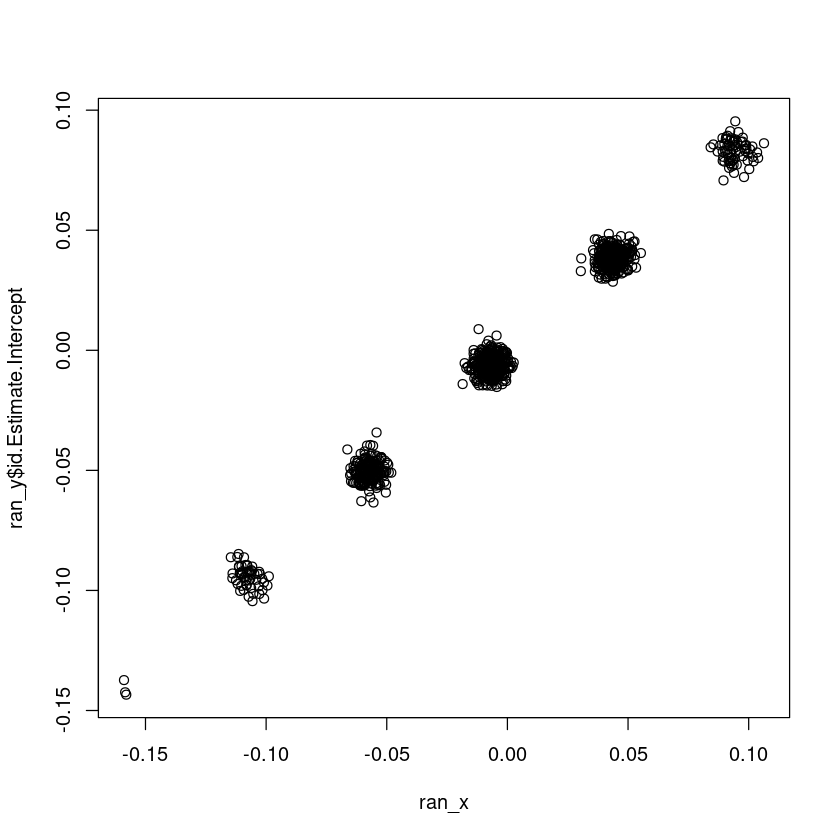

In [159]:
ran_y = ranef(fit) |> data.frame()
ran_x = precis(m_rasch, pars = 'v_Intercept', digits = 3, depth=2)$mean

plot(ran_x, ran_y$id.Estimate.Intercept)

In [142]:
length(precis(m_rasch, pars = 'v_Intercept', digits = 3, depth=2)$mean)

[1] 1000

In [155]:
ran_y$id.Estimate.Intercept

[1] -5.050906e-03  4.371677e-02 -9.311947e-02  7.887303e-02  8.654923e-02
   [6] -5.590171e-03 -1.025529e-02 -6.576868e-03 -7.349351e-03 -4.467450e-02
  [11] -9.505542e-03 -6.514547e-03  3.992079e-02 -5.381097e-03 -9.621286e-04
  [16]  4.321609e-02 -4.781690e-02  4.120439e-02 -9.223429e-02  3.955122e-02
  [21] -4.881663e-02 -1.116309e-02 -6.617490e-03 -5.976656e-03 -1.887512e-03
  [26]  4.441764e-02 -6.124787e-03 -1.299477e-02  3.777687e-02 -4.787245e-02
  [31]  8.796831e-02  7.732438e-02 -5.094230e-03  3.860948e-02 -9.742314e-03
  [36] -9.668170e-02 -5.090874e-02  7.893711e-02 -1.057845e-02 -6.311586e-03
  [41] -7.153641e-03  4.133330e-02 -2.401141e-03 -5.350094e-03 -6.957103e-03
  [46]  3.681493e-02  4.038618e-02 -4.744825e-02  3.572304e-02 -1.434151e-01
  [51] -4.596483e-02 -4.654129e-03 -4.374113e-02 -5.184304e-02  3.523137e-02
  [56] -6.676811e-03  7.997394e-02  3.744778e-02  4.217708e-02 -5.098611e-02
  [61]  3.662734e-02 -4.765651e-02 -9.246864e-02  3.662026e-02  3.673123e-02
  [66] -1.361818e-02 -1.028216e-02 -9.354414e-02 -4.684256e-02  4.974376e-04
  [71] -1.413988e-02 -1.289172e-02  8.809799e-03  4.113311e-02 -5.454584e-02
  [76] -5.463729e-02  4.427695e-02 -3.503762e-03  3.829421e-02 -5.129070e-02
  [81]  3.485668e-02 -4.745193e-02  3.627545e-02  7.725012e-02  5.526731e-04
  [86] -1.265593e-02 -5.289118e-02 -9.323843e-03  2.981737e-02 -8.392031e-03
  [91] -3.627985e-03 -7.383850e-03 -1.010780e-02  4.401692e-02 -5.893153e-03
  [96]  8.052862e-02 -5.236642e-02 -1.215614e-02  8.365946e-02  3.210654e-02
 [101]  3.963866e-02 -1.114862e-03  8.877749e-02  8.378457e-02 -4.599717e-02
 [106] -9.578488e-03 -5.496303e-02 -5.328581e-02 -1.170177e-02  3.780039e-02
 [111]  9.089201e-02 -4.062113e-04 -5.037354e-02 -9.261087e-03 -5.097561e-02
 [116] -3.069192e-03  3.391057e-02  3.713298e-02  3.953693e-02 -8.141657e-03
 [121] -5.868342e-03  3.644048e-02 -5.638193e-03 -4.496578e-03 -5.240403e-02
 [126]  3.853819e-02  3.841799e-02 -2.131293e-03 -6.829156e-03  8.054840e-02
 [131]  3.845341e-02 -5.016004e-02  7.794085e-02 -5.098128e-02 -5.200871e-02
 [136]  4.059639e-02 -5.524699e-02  3.700547e-02 -5.264004e-02  8.855694e-02
 [141] -5.673122e-03  3.296105e-02  3.633040e-02 -1.260105e-02 -4.293616e-03
 [146] -4.631880e-02  4.042347e-02 -4.683974e-02 -6.710745e-03 -3.976717e-02
 [151] -9.487840e-02  4.552948e-02 -1.212949e-02 -8.160888e-03 -5.479737e-02
 [156]  8.327702e-02  8.935263e-02  3.725462e-02  3.676236e-02 -5.237922e-02
 [161] -1.528563e-02  2.525618e-03 -9.447004e-02 -1.249927e-02 -5.116631e-02
 [166] -1.075844e-02  3.394978e-02 -1.336222e-03  3.471028e-02 -5.159878e-02
 [171]  3.525679e-02 -1.023958e-02  3.893524e-02 -1.247502e-02 -9.394885e-03
 [176]  3.618322e-02 -5.300447e-02 -4.841596e-02 -1.997174e-03  4.332601e-02
 [181] -4.661998e-03 -1.458854e-02 -7.064273e-03 -4.704558e-02 -1.108681e-03
 [186]  4.249592e-02 -4.583039e-02 -5.093257e-02  3.750953e-02 -4.712337e-02
 [191] -8.780920e-03 -1.019752e-02  3.579714e-02  3.760546e-02 -5.057731e-02
 [196] -3.580987e-03 -5.410556e-02  3.676316e-02 -3.702711e-03  3.504065e-02
 [201] -3.228146e-03  6.134920e-03  7.855344e-02 -1.282717e-02 -6.531021e-03
 [206] -3.686140e-03 -5.212185e-02  3.906930e-02 -1.056051e-03 -1.003685e-02
 [211] -8.006873e-03 -5.300859e-02 -4.004564e-03 -5.603485e-02 -5.349674e-02
 [216]  2.855747e-02 -3.203058e-03  3.295019e-02 -9.795708e-03  4.052395e-02
 [221]  3.543258e-02 -3.804190e-03 -3.303719e-03 -6.070801e-03  3.758610e-02
 [226] -5.044893e-02 -4.549027e-03 -4.617893e-03 -2.003779e-03  4.622104e-02
 [231]  4.742362e-02  4.131659e-02 -6.918060e-03 -8.227020e-03 -1.553083e-03
 [236]  3.929404e-02 -9.127121e-03  3.694830e-02 -8.599053e-03 -2.262693e-03
 [241] -4.110042e-03 -6.264136e-03 -5.522887e-02 -6.592849e-03 -1.007505e-03
 [246] -7.713209e-03  4.019768e-02 -9.900520e-02  4.265064e-02 -4.743393e-02
 [251] -5.068574e-02 -2.162090e-03 -4.515980e-03 -4.793295e-02 -1.137573e-03
 [256] -1.205297e-02 -8.727634e-03 -7.218951e-03  8.256742e-02 -1.050789e-02